In [1]:
# importing necessary packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
#!pip install imblearn
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

In [2]:
df = pd.read_csv(r"C:\Users\brzro\concordia_bootcamp\bank_marketing\data\bank-additional\bank-additional-full.csv", sep = ';')
pd.set_option('display.max_columns', None)

In [3]:
# There is no missing values, let's drop the duplicates, there are 12 duplicates.

print(df.isnull().sum().sum())
df = df.drop_duplicates()
dff = df.copy()

0


In [4]:
df = df.drop('duration', axis = 1) # duration is known only after the call, it must be removed 

In [5]:
# Creating lists for numeical and catergorical variables.

numerics = ['age', 'campaign', 'previous', 'emp.var.rate',
            'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed']
categoricals = ['job', 'marital', 'education', 'default', 'housing',
                    'loan', 'contact', 'month', 'day_of_week', 'poutcome']

In [6]:
# Creating dummy variables for pdays.

df['pdays'] = np.where(df['pdays'] == 999, 0, 1) # over 95% of people have not been contacted
# Therefore, I created a dummy variable of 0,1 ,where 0 indicated they have not been contacted
# and 1 indicates they have.

In [7]:
df.pdays.value_counts()

0    39661
1     1515
Name: pdays, dtype: int64

In [8]:
rs = 12 ### setting a global random_state

In [9]:
# creating dummy variable for y (dependent variable)

df['y'] = np.where(df['y'] == 'yes', 1, 0)
df['y'].value_counts()

0    36537
1     4639
Name: y, dtype: int64

In [10]:
df['campaign'] = np.where(df['campaign'] > 9, 9, df['campaign'])
# campaign has a very large variance, I used mean(campaign)+2.3*std(campaign) = 9 to set a threshold.

In [11]:
df['campaign'].value_counts()
# checking that the dummies are created correctly.

1    17634
2    10568
3     5340
4     2650
5     1599
9     1377
6      979
7      629
8      400
Name: campaign, dtype: int64

In [12]:
df = pd.get_dummies(df, columns=categoricals, drop_first=True)
# getting the dummies for the categorical variables

In [13]:
# creating vectors of independent vars and dependent var.
X = df.drop('y', axis = 1) 
y = df.y

In [15]:
#X

### Imbalanced Data

Since the data is relatively imbalanced we need to do a couple of adjustments.

1- setting the stratify = dependent variable for the train_test_split.
2- setting the class_weight = 'balanced' in the machine learning models.
3- undersampling (if time allows)


### Metrics used to evaluate the performance

Using accuracy score on an imbalanced data can be misleading. For example, if we just predict 0 regardless of the values of the independent variables, we can get an accuracy score of around 88%.

To account for this issue, we use two other metrics: 
1- balanced accuracy score, which accounts for the sample imbalancedness.
2- Area Undedr the Curve (AUC)




In [16]:
# do the train_test_split.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rs, stratify=y)

In [17]:
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.20, random_state=rs, stratify=y_train)

In [18]:
scalar = StandardScaler()

In [19]:
# since most machine learning algorithms work best when we have almost similar range for each variable
# we scaled the data
X_t_scaled = X_t.copy()

In [20]:
X_t_scaled[numerics] = scalar.fit_transform(X_t_scaled[numerics])

In [21]:
X_v_scaled = X_v.copy()
X_v_scaled[numerics] = scalar.transform(X_v_scaled[numerics])


In [23]:
#X_v_scaled

In [25]:
#X_t_scaled

The data is ready for further analysis

### Logistic Regression

In [73]:
#LR
# to see the effect of the balanced class weight, ran tow regressions.
LR1=LogisticRegression(random_state=rs, max_iter=1_000_000)
LR2 = LogisticRegression(random_state=rs, max_iter=1_000_000, class_weight='balanced')
LR1.fit(X_t_scaled, y_t)
LR2.fit(X_t_scaled, y_t)

LogisticRegression(class_weight='balanced', max_iter=1000000, random_state=12)

In [74]:
pred_lr1 = LR1.predict(X_v_scaled)
pred_lr2 = LR2.predict(X_v_scaled)

In [75]:
print('Classification Report Model 1\n',classification_report(y_v, pred_lr1),'\n\n')
print('Classification Report Model 2 (with class weight = balanced)\n',classification_report(y_v, pred_lr2))

Classification Report Model 1
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      5846
           1       0.61      0.21      0.31       742

    accuracy                           0.90      6588
   macro avg       0.76      0.60      0.63      6588
weighted avg       0.87      0.90      0.87      6588
 


Classification Report Model 2 (with class weight = balanced)
               precision    recall  f1-score   support

           0       0.94      0.85      0.89      5846
           1       0.33      0.59      0.42       742

    accuracy                           0.82      6588
   macro avg       0.64      0.72      0.66      6588
weighted avg       0.87      0.82      0.84      6588



In [76]:
print('balanced accuracy of Model 1',balanced_accuracy_score(y_v, pred_lr1))
print('Confusion Matrix of Model 1\n', confusion_matrix(y_v, pred_lr1))
print('balanced accuracy of Model 2',balanced_accuracy_score(y_v, pred_lr2))
print('Confusion Matrix of Model 2\n', confusion_matrix(y_v, pred_lr2))


balanced accuracy of Model 1 0.5960656398320597
Confusion Matrix of Model 1
 [[5748   98]
 [ 587  155]]
balanced accuracy of Model 2 0.7203651585667349
Confusion Matrix of Model 2
 [[4948  898]
 [ 301  441]]


In [337]:
pred_proba_lr = LR2.predict_proba(X_v_scaled)[:,1]

In [338]:
pred_proba_lr

array([0.24277137, 0.50091095, 0.63634766, ..., 0.19007191, 0.20051256,
       0.17203082])

In [220]:
auc_score_dict = {}

In [339]:
AUC = roc_auc_score(y_v, pred_proba_lr)
print(AUC)
auc_score_dict['LR AUC'] = AUC

0.7624885539263375


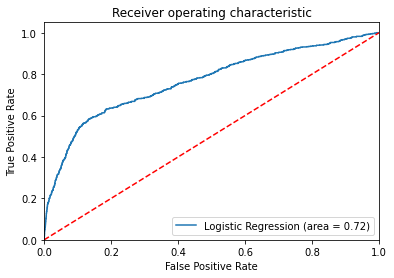

In [341]:
# roc curve

logit_roc_auc = roc_auc_score(y_v, LR2.predict(X_v_scaled))
fpr, tpr, thresholds = roc_curve(y_v, LR2.predict_proba(X_v_scaled)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

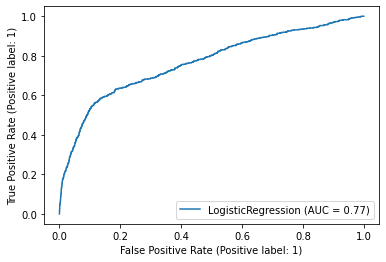

In [342]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(LR2,X_v_scaled,y_v);

### GridSearchCV & Logistic Regression

In [213]:
param_grid = [    
    {'penalty' : ['l1','l2','elasticnet', 'none'], 
    'C' :np.linspace(-2,3,25),
    'solver' : ['lbfgs', 'saga','sag'] 
    
    }
]

In [214]:
#GS = GridSearchCV(LR2, param_grid = param_grid, cv = 3, verbose=True, n_jobs= -1)

In [215]:
#best_GS = GS.fit(X_t_scaled,y_t)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


In [216]:
#best_GS.best_estimator_

LogisticRegression(C=0.08333333333333348, class_weight='balanced',
                   max_iter=1000000, penalty='none', random_state=12)

In [217]:
#pred_lr_GS =best_GS.predict(X_v_scaled)

In [218]:
#print('Classification Report Model 2 with GridSearch (with class weight = balanced)\n',classification_report(y_v, pred_lr_GS))

Classification Report Model 2 with GridSearch (with class weight = balanced)
               precision    recall  f1-score   support

           0       0.98      0.86      0.92      5846
           1       0.44      0.88      0.58       742

    accuracy                           0.86      6588
   macro avg       0.71      0.87      0.75      6588
weighted avg       0.92      0.86      0.88      6588



### SGD Classifier

In [77]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=rs, class_weight='balanced', loss='log_loss')

In [78]:
sgd.fit(X_t_scaled, y_t)

SGDClassifier(class_weight='balanced', loss='log_loss', random_state=12)

In [79]:
pred_sgd = sgd.predict(X_v_scaled)

In [80]:
print('Classification Report SGD \n',classification_report(y_v, pred_sgd),'\n\n')

Classification Report SGD 
               precision    recall  f1-score   support

           0       0.94      0.84      0.89      5846
           1       0.32      0.59      0.42       742

    accuracy                           0.82      6588
   macro avg       0.63      0.72      0.65      6588
weighted avg       0.87      0.82      0.84      6588
 




In [81]:
print('balanced accuracy of Model 1',balanced_accuracy_score(y_v, pred_sgd))

balanced accuracy of Model 1 0.717820049740279


In [82]:
AUC = roc_auc_score(y_v, sgd.predict_proba(X_v_scaled)[:,1])
print(AUC)
auc_score_dict['SGD AUC'] = AUC

0.7624885539263375


NameError: name 'auc_score_dict' is not defined

### Support Vector Machines

In [83]:
svc = SVC(random_state=rs, class_weight='balanced')

In [84]:
svc.fit(X_t_scaled, y_t)

SVC(class_weight='balanced', random_state=12)

In [85]:
pred_svc = svc.predict(X_v_scaled)

In [352]:
print(classification_report(y_v, pred_svc))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      5846
           1       0.38      0.57      0.45       742

    accuracy                           0.84      6588
   macro avg       0.66      0.73      0.68      6588
weighted avg       0.88      0.84      0.86      6588



In [86]:
print(balanced_accuracy_score(y_v, pred_svc))

0.7263367123648948


In [240]:
# param={'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
#       'C':np.arange(0.1,3,10),
#       'degree':np.arange(3,6),   
#       'coef0':np.arange(0.001,3,0.5),
#       'gamma': ('auto', 'scale')}

In [241]:
#GS_svc = GridSearchCV(svc, param_grid = param, cv = 3, verbose=True, n_jobs= -1)

In [288]:
#best_GS_svc = GS_svc.fit(X_t_scaled,y_t)

In [ ]:
#pred_svc_GS =best_GS_svc.predict(X_v_scaled)

### Decision Tree

In [63]:
# setting parameters for a grid search
param= {'max_depth' : (2,3,4,5,6,7,8,9)
              , 'criterion' : ('gini', 'entropy')
              , 'max_features' : ('auto', 'sqrt', 'log2')
              , 'min_samples_split' : (2,5,6,7,8,9,12,16)
             }

In [64]:
tree_grid  = GridSearchCV(DecisionTreeClassifier(random_state=12, class_weight='balanced'), param_grid=  param, cv = 5, 
                          verbose = True)

In [65]:
tree_grid.fit(X_t_scaled,y_t)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=12),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': (2, 3, 4, 5, 6, 7, 8, 9),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'min_samples_split': (2, 5, 6, 7, 8, 9, 12, 16)},
             verbose=True)

In [66]:
tree_grid.best_estimator_
# getting the best parameters of the DT.

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       max_features='auto', random_state=12)

In [67]:
tree_best = DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       max_features='auto', random_state=12)

In [68]:
tree_best.fit(X_t_scaled, y_t)

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       max_features='auto', random_state=12)

In [69]:
pred_tree_best = tree_best.predict(X_v_scaled)

In [70]:
print(round(balanced_accuracy_score(y_v, pred_tree_best),2))

0.68


### Ensemble

In [93]:
from sklearn.ensemble import VotingClassifier
vot = VotingClassifier(
estimators=[('lr',LR2), ('sgd', sgd),('svc', svc), ('tree', tree_best)],
voting = 'hard')

In [94]:
vot.fit(X_t_scaled, y_t)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000000,
                                                 random_state=12)),
                             ('sgd',
                              SGDClassifier(class_weight='balanced',
                                            loss='log_loss', random_state=12)),
                             ('svc',
                              SVC(class_weight='balanced', random_state=12)),
                             ('tree',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=3,
                                                     max_features='auto',
                                                     random_state=12))])

In [95]:
pred_vot = vot.predict(X_v_scaled)

In [96]:
print(balanced_accuracy_score(y_v, pred_vot))

0.7217675043087033


In [98]:
AUC = roc_auc_score(y_v, pred_vot)
print(AUC)


0.7217675043087032


In [302]:
#!pip install xgboost

In [97]:
import xgboost as xgb

In [309]:
xgb_clf = xgb.XGBClassifier(random_state = rs)

In [310]:
xgb_clf.fit(X_t_scaled, y_t)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=12, ...)

In [311]:
pred_xgb = xgb_clf.predict(X_v_scaled)

In [312]:
print(balanced_accuracy_score(y_v , pred_xgb))

0.6125724226392963
